In [1117]:
import os
import xml.etree.ElementTree as ET
# from _mir_hook import mir
from collections import namedtuple, defaultdict
from shapely.geometry import MultiPolygon, Point, Polygon
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from time import time
from skimage.io import imshow
from PIL import Image

import sys
# https://github.com/computationalpathologygroup/ASAP/releases
# Automated Slide Analysis Platform (ASAP) is an open source platform
if 'D:\\ACDC_LUNG_HISTOPATHOLOGY\\ASAP 1.9\\bin' not in sys.path:
    sys.path.append('D:\\ACDC_LUNG_HISTOPATHOLOGY\\ASAP 1.9\\bin')
import multiresolutionimageinterface as mir  # noqa pylint: disable=import-error


In [2]:
_Slide = namedtuple(
    '_Slide',
    ['slide_path', 'xml_cancer_path', 'xml_tissue_path', 'mask_path']
)

_PolygonRaw = namedtuple('_Polygon', ['slide_path', 'name', 'coord'])

_Polygon = namedtuple('_Polygon', ['slide_path', 'area', 'coord'])

def get_files(path):
    for name in os.listdir(path + 'slides/'):
        yield _Slide(
            path + 'slides/' + name,
            path + 'annotations/' + name.split('.')[0] + '.xml',
            path + 'annotations/' + name.split('.')[0] + '_G.xml',
            path + 'masks/' + name.split('.')[0] + '_M.tif'
        )

In [3]:
files=list(get_files('../data/'))
np.random.shuffle(files)
train_files, valid_files = (files[:-len(files) // 10], files[-len(files) // 10:])

In [ ]:
# train_files

In [4]:
def get_coordinate(_list, cancer=True):
    for el in _list:
        if cancer:
            xmlfile=el.xml_cancer_path
        else:
            xmlfile=el.xml_tissue_path
        for ann in ET.parse(xmlfile).getroot().find('Annotations'):
            yx=[(int(float(coord.attrib['Y'])), int(float(coord.attrib['X']))) for coord in ann.find('Coordinates').findall('Coordinate')]  
            yield _PolygonRaw(el.slide_path, ann.attrib['Name'], yx)

In [ ]:
train_coords=list(get_coordinate(train_files))
train_coords=list(get_coordinate(train_files, cancer=False))

In [ ]:
# def get_area(_list):
#     yield [Polygon(el.coord).area for el in _list]

In [ ]:
# train_area=np.array(list(get_area(train_coords)))

In [5]:
def clear_coords(_list):
    for el in _list:
        p = Polygon(el.coord)
        area = p.area
        if area > 1024*1024:
            yield _Polygon(el.slide_path, area, p)

In [ ]:
clear_train_coords=list(clear_coords(train_coords))

In [ ]:
# def _help(_list):
#     return np.unique([el.slide_path for el in _list], return_counts=True)

In [6]:
def get_dict(source_files, cancer=True):
    d = defaultdict(list)
    for path, area, coord in clear_coords(get_coordinate(source_files, cancer=cancer)):
        d[path].append((area, coord))
    return d

In [ ]:
# [c.coord for c in clear_train_coords]

In [ ]:
# dict(d)

In [15]:
f=get_dict(train_files)

In [8]:
f1=get_dict(train_files, cancer=False)

In [ ]:
it = iter(f1.items())

In [ ]:
next(it)

In [9]:
def to_multi(_list):
    return MultiPolygon([[p.exterior.coords, []] for _, p in _list]).buffer(0)

In [561]:
def subtraction(f, f1):
    for k in (set(f) & set(f1)):
        gt = f1[k]
        canc = f[k]
        mp = to_multi(canc)
        tmp = ((poly.buffer(5) - mp) for _, poly in gt)
        f1[k] = [(p.area, p) for p in tmp]
    return(f, f1)

In [562]:
f,f1=subtraction(f,f1)

In [563]:
dict(f1)

{'../data/slides/41A.tif': [(5564385.146339202,
   <shapely.geometry.polygon.Polygon at 0x1a28c1630f0>),
  (1150300.071050845,
   <shapely.geometry.multipolygon.MultiPolygon at 0x1a28c163dd8>),
  (2597398.5172686656, <shapely.geometry.polygon.Polygon at 0x1a28c1636a0>)],
 '../data/slides/10A.tif': [(345407642.1677238,
   <shapely.geometry.polygon.Polygon at 0x1a28c16dfd0>)],
 '../data/slides/14.tif': [(1826748.043720168,
   <shapely.geometry.multipolygon.MultiPolygon at 0x1a28c163080>),
  (16473863.131361352,
   <shapely.geometry.multipolygon.MultiPolygon at 0x1a28c163f28>),
  (12761296.001248538,
   <shapely.geometry.multipolygon.MultiPolygon at 0x1a28c163898>),
  (16973054.45611831,
   <shapely.geometry.multipolygon.MultiPolygon at 0x1a28c163c18>)],
 '../data/slides/36.tif': [(886968496.2015077,
   <shapely.geometry.multipolygon.MultiPolygon at 0x1a28e132470>)],
 '../data/slides/1.tif': [(9066294.548726788,
   <shapely.geometry.polygon.Polygon at 0x1a28e132128>),
  (11649453.09457411

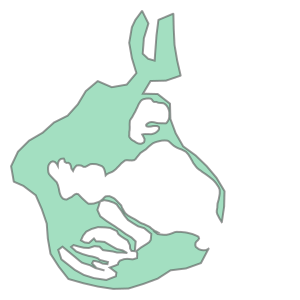

In [564]:
f1['../data/slides/32A.tif'][0][1]

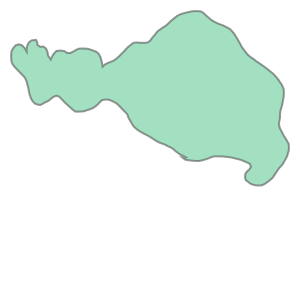

In [630]:
f['../data/slides/32A.tif'][0][1]

In [ ]:
f1['../data/slides/47A.tif']

In [845]:
from threading import local, get_ident
_TLS = local()  # thread-local storage


def tls_prng():
    # pylint: disable=no-member
    try:
        return _TLS.prng
    except AttributeError:
        _TLS.prng = np.random.RandomState(
            (get_ident() + np.random.get_state()[1][0]) % 2**32
        )
        return _TLS.prng
    
def get_random_points(polygon, number):
    prng = tls_prng()

    if not polygon.area:
        return

    minx, miny, maxx, maxy = polygon.bounds
    for _ in range(number):
        while True:
            p = Point(prng.uniform(minx, maxx), prng.uniform(miny, maxy))
            if polygon.contains(p):
                yield (int(p.coords[0][0]), int(p.coords[0][1]))
                break

In [846]:
list(get_random_points(f['../data/slides/32A.tif'][2][1], 1))

[(127916, 33998)]

In [847]:
f['../data/slides/41A.tif']

[(2430961.0, <shapely.geometry.polygon.Polygon at 0x1a283e29cf8>),
 (2433498.0, <shapely.geometry.polygon.Polygon at 0x1a283e96240>),
 (4889551.5, <shapely.geometry.polygon.Polygon at 0x1a283e96438>)]

In [874]:
_Data = namedtuple('_Data', ['slide_path', 'mask_path', 'coord', 'whiteness'])

In [889]:
list(get_random_points(f['../data/slides/41A.tif'][1][1],1))[0]

(84902, 6629)

In [891]:
list(get_random_points(f1['../data/slides/41A.tif'][1][1],1))[0]

(88534, 21182)

In [ ]:
zoom=1
patch_size=(512,512)

np.random.seed(int(time() * 1000) % 2**32)
reader = mir.MultiResolutionImageReader()


random_mask='../data/masks/'+random_slide.split('/')[-1].split('.')[0]+'_M.tif'

random_polygon=random.choice(f[random_slide])[1]
random_points=list(get_random_points(random_polygon,1))

for yx in chain(random_points):
    mask_patch = mask.getUCharPatch(
        startY=yx[0],
        startX=yx[1],
        height=patch_size[0],
        width=patch_size[1],
        level=zoom)
    mask_patch = mask_patch[:, :, 0]
    mask_patch = Image.fromarray(mask_patch * 255)
    mask_patch = mask_patch.convert('L')


In [1473]:
random_slide=random.choice(list(f.keys()))
f[random_slide]

[(2318522.5, <shapely.geometry.polygon.Polygon at 0x1a2840ae2e8>),
 (2719457.5, <shapely.geometry.polygon.Polygon at 0x1a2840aeda0>),
 (5837636.0, <shapely.geometry.polygon.Polygon at 0x1a2840ae240>)]

In [1474]:
random_slide

'../data/slides/29A.tif'

In [ ]:
import os
import xml.etree.ElementTree as ET
from collections import namedtuple
from itertools import chain
from multiprocessing import Process, Queue
from multiprocessing.dummy import Pool
from threading import local, get_ident
from time import time

import numpy as np
from PIL import Image
from shapely.geometry import MultiPolygon, Point, Polygon
from tqdm import tqdm

from ._mir_hook import mir

_TLS = local()  # thread-local storage


def tls_prng():
    # pylint: disable=no-member
    try:
        return _TLS.prng
    except AttributeError:
        _TLS.prng = np.random.RandomState(
            (get_ident() + np.random.get_state()[1][0]) % 2**32
        )
        return _TLS.prng


def get_files(imagesP, masksP, xmlsP):
    for name in os.listdir(imagesP):
        name = name.split('.tif')[0]
        yield {
            'imageP': imagesP + name + '.tif',
            'maskP': masksP + name + '_M.tif',
            'cancerxmlP': xmlsP + name + '.xml',
            'groundxmlP': xmlsP + name + '_G.xml'
        }


def get_coordinates(xmlP):
    for ann in ET.parse(xmlP).getroot().find('Annotations'):
        yield [
            (int(float(coord.attrib['Y'])), int(float(coord.attrib['X'])))
            for coord in ann.find('Coordinates').findall('Coordinate')
        ]  # <- it's "p"


def to_multipolygon(yx):
    return MultiPolygon([[p, []] for p in yx]).buffer(0)  # <- this one "p"


def get_random_points(polygon, number):
    prng = tls_prng()

    if not polygon.area:
        return

    minx, miny, maxx, maxy = polygon.bounds
    for _ in range(number):
        while True:
            p = Point(prng.uniform(minx, maxx), prng.uniform(miny, maxy))
            if polygon.contains(p):
                yield (int(p.coords[0][0]), int(p.coords[0][1]))
                break

    # for _ in range(number):
    #     p = polygon.representative_point()
    #     yield (int(p.coords[0][0]), int(p.coords[0][1]))


_Cancer = namedtuple('_Cancer', ['SlideP', 'MaskP', 'Coord', 'Whiteness'])


def get_data_unsafe(list_of_data, patch_size, zoom, nbpoints):
    np.random.seed(int(time() * 1000) % 2**32)
    reader = mir.MultiResolutionImageReader()

    # for data in list_of_data:
    def read_generator(data):
        mask = reader.open(data['maskP'])
        canc_poly = to_multipolygon(get_coordinates(data['cancerxmlP']))
        whole_poly = to_multipolygon(get_coordinates(data['groundxmlP']))

        gt = get_random_points(whole_poly.difference(canc_poly), nbpoints)
        gt = list(gt)
        canc = get_random_points(canc_poly, 2 * nbpoints - len(gt))

        for yx in chain(gt, canc):
            mask_patch = mask.getUCharPatch(
                startY=yx[0],
                startX=yx[1],
                height=patch_size[0],
                width=patch_size[1],
                level=zoom
            )
            mask_patch = mask_patch.astype(bool)
            values, counts = np.unique(mask_patch, return_counts=True)

            yield _Cancer(
                data['imageP'], data['maskP'], yx,
                sum(values * counts) / sum(counts) * 100
            )

    def read(data):
        return list(read_generator(data))

    with Pool(12) as pool:
        for subset in pool.imap_unordered(read, list_of_data):
            yield from subset

    # for data in list_of_data:
    #     yield from read_generator(data)


def get_data_unsafe_queue(q, list_of_data, patch_size, zoom, nbpoints):
    for item in get_data_unsafe(list_of_data, patch_size, zoom, nbpoints):
        q.put(item)
    q.put(None)


def get_data(list_of_data, patch_size, zoom, nbpoints):
    q = Queue()
    p = Process(
        target=get_data_unsafe_queue,
        args=(q, list_of_data, patch_size, zoom, nbpoints)
    )
    p.start()
    try:
        yield from iter(q.get, None)
    finally:
        p.join()
        p.terminate()


def gen_test_data(test_path, patch_size, zoom):
    reader = mir.MultiResolutionImageReader()
    slide = reader.open(test_path)
    w, h = slide.getDimensions()
    coord = np.stack(
        np.meshgrid(
            np.arange(0, h, patch_size[0] * 2**zoom),
            np.arange(0, w, patch_size[1] * 2**zoom),
            indexing='ij'
        ),
        axis=-1
    )
    # coord=coord.reshape((coord.shape[0]*coord.shape[1],2))
    return slide, coord